**Welcome to this Notebook!**

UCLouvain - EPL - made by Justin Weeamels & Baptiste Sambon - 2023

*Step by step you will discover how we implemented and simulated a downlink communication using the Code Divison Multiple Access method.*

*At first, let's import some packages like numpy, sionna, tensorflow, matplotlib, scipy and more importantly our home-made utils.py file. **As said in the README, run this file twice!***

In [2]:
import numpy as np
import sionna
import tensorflow as tf
import utils
import matplotlib.pyplot as plt
from scipy.special import erfc

*This is the initialization of the needed parameters as a dictionay named tx_params. Because we are in a perfect CSI case, these informations will be sent from the BS to the UE as a pilot before any communication.*

In [3]:
tx_params = {
    "nUsers" : 3,               # The number of UEs.
    "powerAllocation_dB" : 0,   # The power allocated to the communication at the BS in dB.
    "nMessage" : 60,            # The number of bits representing the message to send.
    "nCodeCDMA" : 32,           # The number of bits used for the Walsh-Hadamard codes creation.
    "codes" : [],               # The array containing every created Walsh-Hadamard codes.
    "nGold" : 1024              # The number of bits used for the Gold codes creation.
}

# The following arrays contain the needed informations in order to simulate the ICI.
interference_ratio = np.load("data/Interference/ratio_power_interf.npy")
interference_ratio_obstacles = np.load("data/Interference/ratio_power_interf_obstacles.npy")

*In order for you to compare with metrics you already know, we plotted here the BER/SNR curves of both the CDMA method and a basic case with an AWGN channel.*

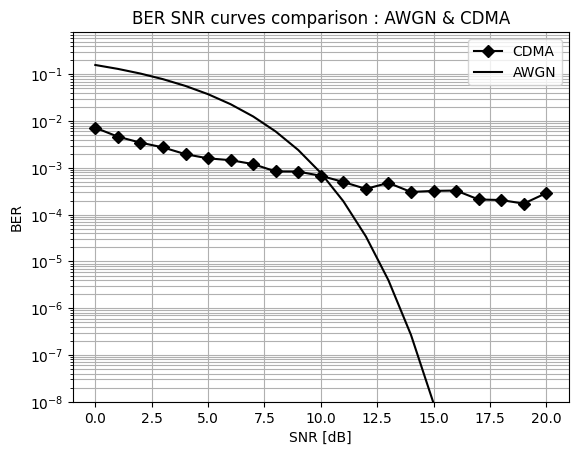

In [13]:
# Initialization of the to-be-send message as a sionna object.
binary_source = sionna.utils.BinarySource()

# Some parameters used to iterate on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1)
nb_seq = 1000
alpha = 0
ber = np.zeros(len(ebn0))

# Crosscorrelation coefficients extracted using the Gold codes to simulate the ICI.
# xCorrNegative is the negative bound and xCorrPositive the positive one of the coefficients.
# xCorrOsef = 1 and won't be used because we only care about the bounds.
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

for i in range(len(ebn0)):

    # Noise variance and ber_i is an array used to compute the final BER mean value for each SNR.
    var_noise = 1/(10**(0.1*ebn0[i]))
    ber_i = np.zeros(nb_seq)

    # Loop on a lot of cases where the communication is reinitialized each time.
    # Each time, a new channel, a new code, new interferences and a new noise are created.
    for j in range(nb_seq):

        # Array containing the random messages for each UE.
        # These messages are encoded following the CDMA method.
        # These -1/+1 messages can now be sent through the channel from the BS to the UE.
        data = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()
        encoded = utils.CDMA_encode(data, tx_params)

        # Creating a Rayleigh fading channel and random complex noise.
        h = utils.Rayleigh_canal(alpha, len(encoded))
        n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape) 
             + np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape))
        
        # This small series of code lines will simulate random data sent by other cells and received by our UE.
        # It will be used with the Gold codes to represent the ICI.
        interferences = 1/np.random.choice(interference_ratio, size=h.shape)
        possible_values = np.sqrt(2)*np.array([1+1j, -1-1j, 1-1j, -1+1j])
        signalOtherCells = np.random.choice(possible_values, size=h.shape)
        
        # The received signal expression will thus be the following line.
        # A sum of the encoded data passing through the channel, some random noise and some random interferences.
        # We represent the Gold codes impact by cancelling the ICI thanks to the crosscorrelation coefficients.
        received = encoded*h + n + interferences*signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]

        # At the UEs, the received data is equalized using MMSE and then decoded with CDMA.
        mmse = utils.MyMMSE(encoded, h, var_noise, received)
        decoded = utils.CDMA_decode(mmse, tx_params)

        # Here we use tensorflow and sionna functions to compute the BER metric of the latter decoded signal.
        decoded_tf = tf.convert_to_tensor(decoded)
        decoded_tf = tf.cast(tf.less(0.0, decoded_tf), tf.float32)
        BinarySource = tf.cast(tf.less(0.0, data), tf.float32)
        ber_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf)
        ber_i[j] = ber_j.numpy()
        
    # Compute the final BER mean value for a specific SNR.
    ber[i] = np.mean(ber_i)

ber_awgn = (1/2)*erfc(np.sqrt(10**(0.1*ebn0)/2))

plt.figure()
plt.semilogy(ebn0, ber, "D-", label="CDMA", color="black")
plt.plot(ebn0, ber_awgn, label="AWGN", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.ylim([10**(-8), 0.8])
plt.title("BER SNR curves comparison : AWGN & CDMA")
plt.savefig("data/CDMA/MyBERSNR.pdf")
plt.show()

*Let's discover the variability of the CDMA method in function of its main parameters. We will begin this kind of dependancy analysis by varying the number of UEs in the scenario.*

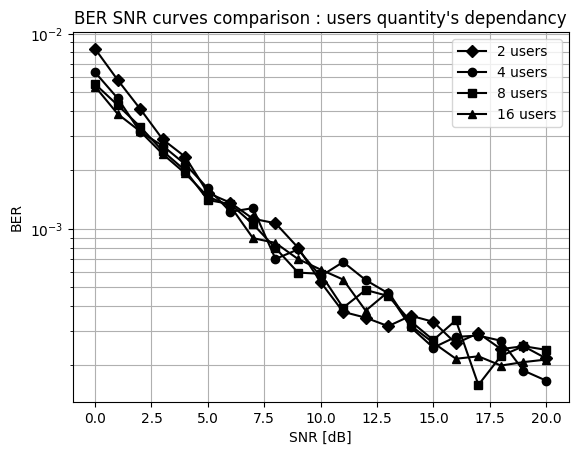

In [5]:
# Varying the number of UEs in the scenario.
UserEquipements = [2, 4, 8, 16]

# Initialization of the to-be-send message as a sionna object.
binary_source = sionna.utils.BinarySource()

# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1)
nb_seq = 1000
alpha = 0
ber = np.zeros(len(ebn0))

# Crosscorrelation coefficients extracted using the Gold codes to simulate the ICI.
# xCorrNegative is the negative bound and xCorrPositive the positive one of the coefficients.
# xCorrOsef = 1 and won't be used because we only care about the bounds.
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

# Creating the environment for the futur plots.
plt.figure()
symbols = ["D-", "o-", "s-", "^-"]

for user in range(len(UserEquipements)):

    # Setting up the current number of UEs in the tx_params dictionary.
    tx_params["nUsers"] = UserEquipements[user]

    for i in range(len(ebn0)):

        # Noise variance and ber_i is an array used to compute the final BER mean value for each SNR.
        var_noise = 1/(10**(0.1*ebn0[i]))
        ber_i = np.zeros(nb_seq)

        # Loop on a lot of cases where the communication is reinitialized each time.
        # Each time, a new channel, a new code, new interferences, a new noise are created.
        for j in range(nb_seq):

            # Array containing the random messages for each UE.
            # These messages are encoded following the CDMA method.
            # These -1/+1 messages can now be sent through the channel from the BS to the UE.
            data = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()
            encoded = utils.CDMA_encode(data, tx_params)

            # Creating a Rayleigh fading channel and random complex noise.
            h = utils.Rayleigh_canal(alpha, len(encoded))
            n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape) 
                + np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape))
            
            # This small series of code lines will simulate random data sent by other cells by received by our UE.
            # It will be used with the Gold codes to represent the ICI.
            interferences = 1/np.random.choice(interference_ratio, size=h.shape)
            possible_values = np.sqrt(2)*np.array([1+1j, -1-1j, 1-1j, -1+1j])
            signalOtherCells = np.random.choice(possible_values, size=h.shape)

            # The received signal expression will thus be the following line.
            # A sum of the encoded data passing through the channel, some random noise and some random interferences.
            # We represent the Gold code action by cancelling the ICI thanks to the crosscorrelation coefficients.
            received = encoded*h + n + interferences*signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]

            # At the UE, the received data is equalized using MMSE and then decoded with CDMA.
            mmse = utils.MyMMSE(encoded, h, var_noise, received)
            decoded = utils.CDMA_decode(mmse, tx_params)

            # Here we use tensorflow and sionna functions to compute the BER metric of the latter decoded signal.
            decoded_tf = tf.convert_to_tensor(decoded)
            decoded_tf = tf.cast(tf.less(0.0, decoded_tf), tf.float32)
            BinarySource = tf.cast(tf.less(0.0, data), tf.float32)
            ber_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf)
            ber_i[j] = ber_j.numpy()
            
        # Compute the final BER mean value for a specific SNR.
        ber[i] = np.mean(ber_i)

    # A nice plot of the corresponding BER/SNR curve for the current UE.
    plt.semilogy(ebn0, ber, symbols[user], label=str(UserEquipements[user])+" users", color="black")

plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.title("BER SNR curves comparison : users quantity's dependancy")
plt.savefig("data/CDMA/MyBERSNRuser.pdf")
plt.show()

# Reset of the initial UE number.
tx_params["nUsers"] = 3

*Let's investigate if the length of the actual message sent by the BS will change the BER metric significantly.*

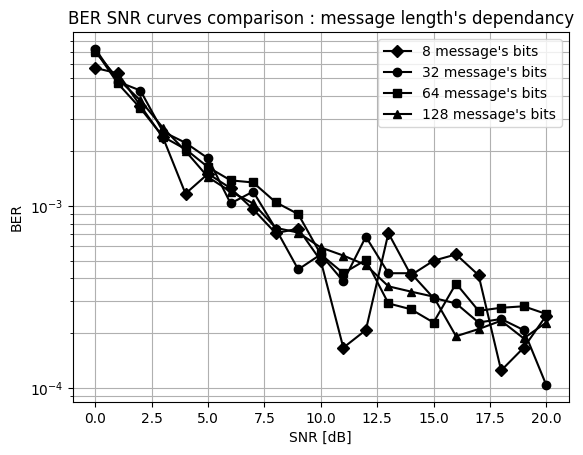

In [6]:
# Varying the number of bits in the message in the scenario.
message = [8, 32, 64, 128]

# Initialization of the to-be-send message as a sionna object.
binary_source = sionna.utils.BinarySource()

# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1)
nb_seq = 1000
alpha = 0
ber = np.zeros(len(ebn0))

# Crosscorrelation coefficients extracted using the Gold codes to simulate the ICI.
# xCorrNegative is the negative bound and xCorrPositive the positive one of the coefficients.
# xCorrOsef = 1 and won't be used because we only care about the bounds.
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

# Creating the environment for the futur plots.
plt.figure()
symbols = ["D-", "o-", "s-", "^-"]

for mes in range(len(message)):

    # Setting up the current message length in the tx_params dictionary.
    tx_params["nMessage"] = message[mes]

    for i in range(len(ebn0)):

        # Noise variance and ber_i is an array used to compute the final BER mean value for each SNR.
        var_noise = 1/(10**(0.1*ebn0[i]))
        ber_i = np.zeros(nb_seq)

        # Loop on a lot of cases where the communication is reinitialized each time.
        # Each time, a new channel, a new code, new interferences, a new noise are created.
        for j in range(nb_seq):

            # Array containing the random messages for each UE.
            # These messages are encoded following the CDMA method.
            # These -1/+1 messages can now be sent through the channel from the BS to the UE.
            data = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()
            encoded = utils.CDMA_encode(data, tx_params)

            # Creating a Rayleigh fading channel and random complex noise.
            h = utils.Rayleigh_canal(alpha, len(encoded))
            n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape) 
                + np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape))
            
            # This small series of code lines will simulate random data sent by other cells by received by our UE.
            # It will be used with the Gold codes to represent the ICI.
            interferences = 1/np.random.choice(interference_ratio, size=h.shape)
            possible_values = np.sqrt(2)*np.array([1+1j, -1-1j, 1-1j, -1+1j])
            signalOtherCells = np.random.choice(possible_values, size=h.shape)

            # The received signal expression will thus be the following line.
            # A sum of the encoded data passing through the channel, some random noise and some random interferences.
            # We represent the Gold code action by cancelling the ICI thanks to the crosscorrelation coefficients.
            received = encoded*h + n + interferences*signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]

            # At the UE, the received data is equalized using MMSE and then decoded with CDMA.
            mmse = utils.MyMMSE(encoded, h, var_noise, received)
            decoded = utils.CDMA_decode(mmse, tx_params)

            # Here we use tensorflow and sionna functions to compute the BER metric of the latter decoded signal.
            decoded_tf = tf.convert_to_tensor(decoded)
            decoded_tf = tf.cast(tf.less(0.0, decoded_tf), tf.float32)
            BinarySource = tf.cast(tf.less(0.0, data), tf.float32)
            ber_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf)
            ber_i[j] = ber_j.numpy()
            
        # Compute the final BER mean value for a specific SNR.
        ber[i] = np.mean(ber_i)

    # A nice plot of the corresponding BER/SNR curve for the current message's length.
    plt.semilogy(ebn0, ber, symbols[mes], label=str(message[mes])+" message's bits", color="black")

plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.title("BER SNR curves comparison : message length's dependancy")
plt.savefig("data/CDMA/MyBERSNRmessage.pdf")
plt.show()

# Reset of the initial message's number of bits.
tx_params["nMessage"] = 60

*Variation of the Gold code's length can also be compared.*

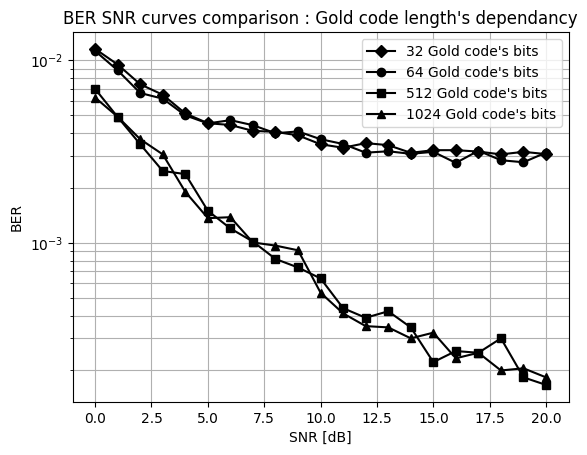

In [7]:
# Varying the number of bits in the gold code sequence.
gold = [32, 64, 512, 1024]

# Initialization of the to-be-send message as a sionna object.
binary_source = sionna.utils.BinarySource()

# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1)
nb_seq = 1000
alpha = 0
ber = np.zeros(len(ebn0))

# Creating the environment for the futur plots.
plt.figure()
symbols = ["D-", "o-", "s-", "^-"]

for silver in range(len(gold)):

    # Crosscorrelation coefficients extracted using the Gold codes to simulate the ICI.
    # xCorrNegative is the negative bound and xCorrPositive the positive one of the coefficients.
    # xCorrOsef = 1 and won't be used because we only care about the bounds.
    tx_params["nGold"] = gold[silver]
    xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

    for i in range(len(ebn0)):

        # Noise variance and ber_i is an array used to compute the final BER mean value for each SNR.
        var_noise = 1/(10**(0.1*ebn0[i]))
        ber_i = np.zeros(nb_seq)

        # Loop on a lot of cases where the communication is reinitialized each time.
        # Each time, a new channel, a new code, new interferences, a new noise are created.
        for j in range(nb_seq):

            # Array containing the random messages for each UE.
            # These messages are encoded following the CDMA method.
            # These -1/+1 messages can now be sent through the channel from the BS to the UE.
            data = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()
            encoded = utils.CDMA_encode(data, tx_params)

            # Creating a Rayleigh fading channel and random complex noise.
            h = utils.Rayleigh_canal(alpha, len(encoded))
            n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape) 
                + np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape))
            
            # This small series of code lines will simulate random data sent by other cells by received by our UE.
            # It will be used with the Gold codes to represent the ICI.
            interferences = 1/np.random.choice(interference_ratio, size=h.shape)
            possible_values = np.sqrt(2)*np.array([1+1j, -1-1j, 1-1j, -1+1j])
            signalOtherCells = np.random.choice(possible_values, size=h.shape)

            # The received signal expression will thus be the following line.
            # A sum of the encoded data passing through the channel, some random noise and some random interferences.
            # We represent the Gold code action by cancelling the ICI thanks to the crosscorrelation coefficients.
            received = encoded*h + n + interferences*signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]

            # At the UE, the received data is equalized using MMSE and then decoded with CDMA.
            mmse = utils.MyMMSE(encoded, h, var_noise, received)
            decoded = utils.CDMA_decode(mmse, tx_params)

            # Here we use tensorflow and sionna functions to compute the BER metric of the latter decoded signal.
            decoded_tf = tf.convert_to_tensor(decoded)
            decoded_tf = tf.cast(tf.less(0.0, decoded_tf), tf.float32)
            BinarySource = tf.cast(tf.less(0.0, data), tf.float32)
            ber_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf)
            ber_i[j] = ber_j.numpy()
            
        # Compute the final BER mean value for a specific SNR.
        ber[i] = np.mean(ber_i)

    # A nice plot of the corresponding BER/SNR curve for the current scrambling code's length.
    plt.semilogy(ebn0, ber, symbols[silver], label=str(gold[silver])+" Gold code's bits", color="black")

plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.title("BER SNR curves comparison : Gold code length's dependancy")
plt.savefig("data/CDMA/MyBERSNRgoldcode.pdf")
plt.show()

# Reset of the initial gold code's number of bits.
tx_params["nGold"] = 1024

*To counter the ICI we use Gold codes as said before. But what would happen if we skip this important step in the precoding? Let's discover it.*

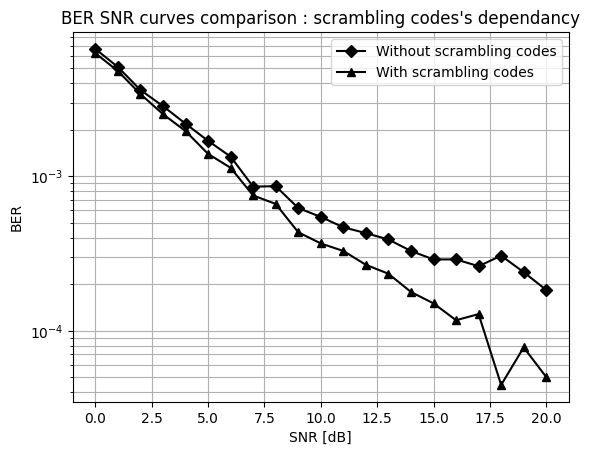

In [14]:
# Initialization of the to-be-send message as a sionna object.
binary_source = sionna.utils.BinarySource()

# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1)
nb_seq = 1000
alpha = 0
ber = np.zeros(len(ebn0))
ber_Gold = np.zeros(len(ebn0))

# Crosscorrelation coefficients extracted using the Gold codes to simulate the ICI.
# xCorrNegative is the negative bound and xCorrPositive the positive one of the coefficients.
# xCorrOsef = 1 and won't be used because we only care about the bounds.
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

for i in range(len(ebn0)):

    # Noise variance and ber_i is an array used to compute the final BER mean value for each SNR.
    var_noise = 1/(10**(0.1*ebn0[i]))
    ber_i = np.zeros(nb_seq)
    ber_Gold_i = np.zeros(nb_seq)

    # Loop on a lot of cases where the communication is reinitialized each time.
    # Each time, a new channel, a new code, new interferences, a new noise are created.
    for j in range(nb_seq):

        # Array containing the random messages for each UE.
        # These messages are encoded following the CDMA method.
        # These -1/+1 messages can now be sent through the channel from the BS to the UE.
        data = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()
        encoded = utils.CDMA_encode(data, tx_params)

        # Creating a Rayleigh fading channel and random complex noise.
        h = utils.Rayleigh_canal(alpha, len(encoded))
        n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape) 
             + np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape))
        
        # This small series of code lines will simulate random data sent by other cells by received by our UE.
        # It will be used with the Gold codes to represent the ICI.
        interferences = 1/np.random.choice(interference_ratio, size=h.shape)
        possible_values = np.sqrt(2)*np.array([1+1j, -1-1j, 1-1j, -1+1j])
        signalOtherCells = np.random.choice(possible_values, size=h.shape)

        # The received signal expression will thus be the following line.
        # A sum of the encoded data passing through the channel, some random noise and some random interferences.
        # We represent the Gold code action by cancelling the ICI thanks to the crosscorrelation coefficients.
        received = encoded*h + n
        received_Gold = encoded*h + n + interferences*signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]

        # At the UE, the received data is equalized using MMSE and then decoded with CDMA.
        mmse = utils.MyMMSE(encoded, h, var_noise, received)
        mmse_Gold = utils.MyMMSE(encoded, h, var_noise, received_Gold)
        decoded = utils.CDMA_decode(mmse, tx_params)
        decoded_Gold = utils.CDMA_decode(mmse_Gold, tx_params)

        # Here we use tensorflow and sionna functions to compute the BER metric of the latter decoded signal.
        decoded_tf = tf.convert_to_tensor(decoded)
        decoded_Gold_tf = tf.convert_to_tensor(decoded_Gold)
        decoded_tf = tf.cast(tf.less(0.0, decoded_tf), tf.float32)
        decoded_Gold_tf = tf.cast(tf.less(0.0, decoded_Gold_tf), tf.float32)
        BinarySource = tf.cast(tf.less(0.0, data), tf.float32)
        ber_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_tf)
        ber_Gold_j = sionna.utils.metrics.compute_ber(BinarySource, decoded_Gold_tf)
        ber_i[j] = ber_j.numpy()
        ber_Gold_i[j] = ber_Gold_j.numpy()
        
    # Compute the final BER mean value for a specific SNR.
    ber[i] = np.mean(ber_i)
    ber_Gold[i] = np.mean(ber_Gold_i)

plt.figure()
plt.semilogy(ebn0, ber_Gold, "D-", label="Without scrambling codes", color="black")
plt.semilogy(ebn0, ber, "^-", label="With scrambling codes", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.title("BER SNR curves comparison : scrambling codes's dependancy")
plt.savefig("data/CDMA/MyBERSNRscramblingcode.pdf")
plt.show()

*Another metric to investigate on is the spectral efficiency of the CDMA method. To do so, as done before, we will iterate on a lot of communications and compute the mean of the capacity for a large number of SNR values.*

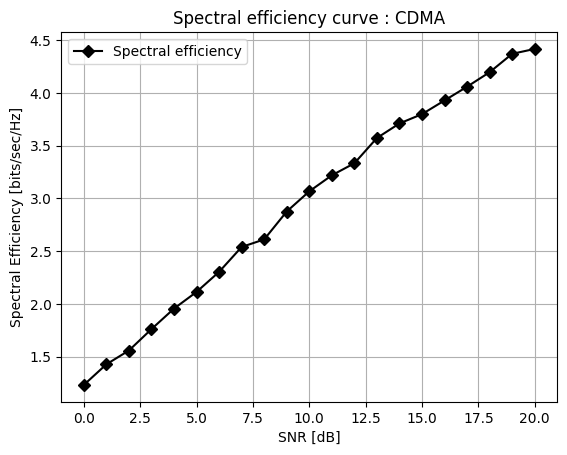

In [10]:
# Initialization of the to-be-send message as a sionna object.
binary_source = sionna.utils.BinarySource()

# Some parameters used to loop on the different SNR values and evaluate the spectral efficiency.
ebn0 = np.arange(0, 21, 1)
# nb_seq = tx_params["nMessage"]*tx_params["nCodeCDMA"]
nb_seq = 1000
alpha = 0
spectral_efficiency = np.zeros(len(ebn0))
p_power = 1

# Crosscorrelation coefficients extracted using the Gold codes to simulate the ICI.
# xCorrNegative is the negative bound and xCorrPositive the positive one of the coefficients.
# xCorrOsef = 1 and won't be used because we only care about the bounds.
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

for i in range(len(ebn0)):

    # Noise variance and spectral_efficiency_i is an array used to compute the final spectral efficiency mean value for each SNR.
    var_noise = 1/(10**(0.1*ebn0[i]))
    spectral_efficiency_i = np.zeros(nb_seq)

    # Loop on a lot of cases where the communication is reinitialized each time.
    # Each time, a new channel, a new code, new interferences, a new noise are created.
    for j in range(nb_seq):

        # Array containing the random messages for each UE.
        # These messages are encoded following the CDMA method.
        # These -1/+1 messages can now be sent through the channel from the BS to the UE.
        data = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()
        encoded = utils.CDMA_encode(data, tx_params)

        # Creating a Rayleigh fading channel and random complex noise.
        h = utils.Rayleigh_canal(alpha, len(encoded))
        n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape) 
             + np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape))
        
        # This small series of code lines will simulate random data sent by other cells by received by our UE.
        # It will be used with the Gold codes to represent the ICI.
        interferences = 1/np.random.choice(interference_ratio, size=h.shape)
        possible_values = np.sqrt(2)*np.array([1+1j, -1-1j, 1-1j, -1+1j])
        signalOtherCells = np.random.choice(possible_values, size=h.shape)

        # Compute the spectral efficiency by using the allocated power and the channel coefficients.
        # But also using the noise and interference values.        
        i_interference = interferences*signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]
        spectral_efficiency_i[j] = np.log2(1+(p_power*abs(h[j])**2)/(var_noise+abs(i_interference[j])))
    
    # Compute the final spectral efficiency mean value for a specific SNR.
    spectral_efficiency[i] = np.mean(spectral_efficiency_i)

plt.figure()
plt.plot(ebn0, spectral_efficiency, "D-", label="Spectral efficiency", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("Spectral Efficiency [bits/sec/Hz]")
plt.xscale("linear")
plt.grid(which="both")
plt.legend()
plt.title("Spectral efficiency curve : CDMA")
plt.savefig("data/CDMA/Myspectralefficiency.pdf")
plt.show()

*Finally we must investigate what kind of parameters will make the spectral efficiency vary. We thus begin with the number of users.*

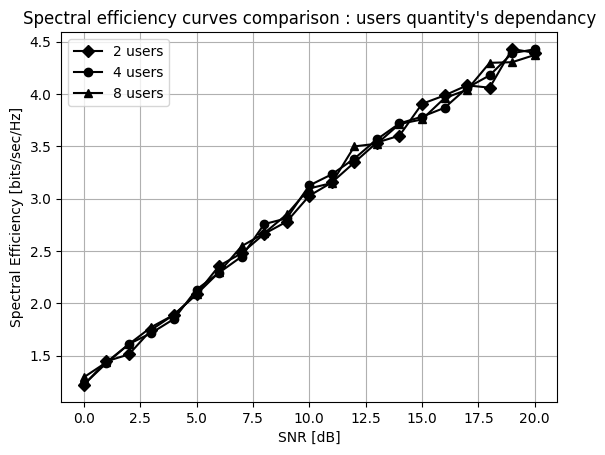

In [11]:
# Varying the number of users.
users = [2, 4, 8]

# Initialization of the to-be-send message as a sionna object.
binary_source = sionna.utils.BinarySource()

# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1)
# nb_seq = tx_params["nMessage"]*tx_params["nCodeCDMA"]
nb_seq = 1000
alpha = 0
spectral_efficiency = np.zeros(len(ebn0))
spectral_efficiency_total = np.zeros(len(ebn0))
p_power = 1

# Crosscorrelation coefficients extracted using the Gold codes to simulate the ICI.
# xCorrNegative is the negative bound and xCorrPositive the positive one of the coefficients.
# xCorrOsef = 1 and won't be used because we only care about the bounds.
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

# Creating the environment for the futur plots.
plt.figure()
symbols = ["D-", "o-", "^-"]

for use in range(len(users)):

    # Setting up the current message length in the tx_params dictionary.
    tx_params["nUsers"] = users[use]
    
    for i in range(len(ebn0)):

        # Noise variance and ber_i is an array used to compute the final BER mean value for each SNR.
        var_noise = 1/(10**(0.1*ebn0[i]))
        spectral_efficiency_i = np.zeros(nb_seq)

        # Loop on a lot of cases where the communication is reinitialized each time.
        # Each time, a new channel, a new code, new interferences, a new noise are created.
        for j in range(nb_seq):

            # Array containing the random messages for each UE.
            # These messages are encoded following the CDMA method.
            # These -1/+1 messages can now be sent through the channel from the BS to the UE.
            data = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()
            encoded = utils.CDMA_encode(data, tx_params)

            # Creating a Rayleigh fading channel and random complex noise.
            h = utils.Rayleigh_canal(alpha, len(encoded))
            n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape) 
                + np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape))
            
            # This small series of code lines will simulate random data sent by other cells by received by our UE.
            # It will be used with the Gold codes to represent the ICI.
            interferences = 1/np.random.choice(interference_ratio, size=h.shape)
            possible_values = np.sqrt(2)*np.array([1+1j, -1-1j, 1-1j, -1+1j])
            signalOtherCells = np.random.choice(possible_values, size=h.shape)

            # Compute the spectral efficiency by using the allocated power and the channel coefficients.
            # But also using the noise and interference values.        
            i_interference = interferences*signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]
            spectral_efficiency_i[j] = np.log2(1+(p_power*abs(h[j])**2)/(var_noise+abs(i_interference[j])))
            
        # Compute the final spectral efficiency mean value for a specific SNR.
        spectral_efficiency[i] = np.mean(spectral_efficiency_i)
        for k in range(len(ebn0)):
            spectral_efficiency_total[k] += spectral_efficiency[k]

    # A nice plot of the corresponding spectral efficiency for the current users's quantity.
    plt.plot(ebn0, spectral_efficiency, symbols[use], label=str(users[use])+" users", color="black")

plt.xlabel("SNR [dB]")
plt.ylabel("Spectral Efficiency [bits/sec/Hz]")
plt.xscale("linear")
plt.grid(which="both")
plt.legend()
plt.title("Spectral efficiency curves comparison : users quantity's dependancy")
plt.savefig("data/CDMA/Myspectralefficiencyuser.pdf")
plt.show()

tx_params["nUsers"] = 3

*Another parameter is the fact that we take obstacles into account or not in the scenario.*

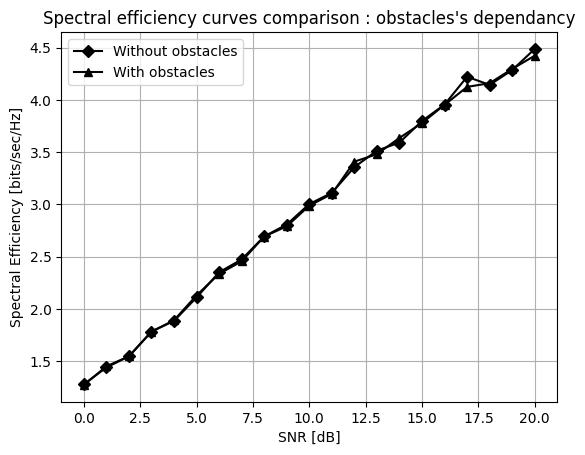

In [12]:
# Initialization of the to-be-send message as a sionna object.
binary_source = sionna.utils.BinarySource()

# Some parameters used to loop on the different SNR values and evaluate the spectral efficiency.
ebn0 = np.arange(0, 21, 1)
# nb_seq = tx_params["nMessage"]*tx_params["nCodeCDMA"]
nb_seq = 1000
alpha = 0
spectral_efficiency = np.zeros(len(ebn0))
spectral_efficiency_o = np.zeros(len(ebn0))
p_power = 1

# Crosscorrelation coefficients extracted using the Gold codes to simulate the ICI.
# xCorrNegative is the negative bound and xCorrPositive the positive one of the coefficients.
# xCorrOsef = 1 and won't be used because we only care about the bounds.
xCorrNegative, xCorrOsef, xCorrPositive = utils.goldcode(tx_params["nGold"])

for i in range(len(ebn0)):

    # Noise variance and spectral_efficiency_i is an array used to compute the final spectral efficiency mean value for each SNR.
    var_noise = 1/(10**(0.1*ebn0[i]))
    spectral_efficiency_i = np.zeros(nb_seq)
    spectral_efficiency_o_i = np.zeros(nb_seq)

    # Loop on a lot of cases where the communication is reinitialized each time.
    # Each time, a new channel, a new code, new interferences, a new noise are created.
    for j in range(nb_seq):

        # Array containing the random messages for each UE.
        # These messages are encoded following the CDMA method.
        # These -1/+1 messages can now be sent through the channel from the BS to the UE.
        data = binary_source([tx_params["nUsers"], tx_params["nMessage"]]).numpy()
        encoded = utils.CDMA_encode(data, tx_params)

        # Creating a Rayleigh fading channel and random complex noise.
        h = utils.Rayleigh_canal(alpha, len(encoded))
        n = (1j*np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape) 
             + np.random.normal(scale=np.sqrt(var_noise/2),size=encoded.shape))
        
        # This small series of code lines will simulate random data sent by other cells by received by our UE.
        # It will be used with the Gold codes to represent the ICI.
        interferences = 1/np.random.choice(interference_ratio, size=h.shape)
        interferences_o = 1/np.random.choice(interference_ratio_obstacles, size=h.shape)
        possible_values = np.sqrt(2)*np.array([1+1j, -1-1j, 1-1j, -1+1j])
        signalOtherCells = np.random.choice(possible_values, size=h.shape)

        # Compute the spectral efficiency by using the allocated power and the channel coefficients.
        # But also using the noise and interference values.        
        i_interference = interferences*signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]
        spectral_efficiency_i[j] = np.log2(1+(p_power*abs(h[j])**2)/(var_noise+abs(i_interference[j])))

        i_interference_o = interferences_o*signalOtherCells*(xCorrPositive-xCorrNegative)/tx_params["nGold"]
        spectral_efficiency_o_i[j] = np.log2(1+(p_power*abs(h[j])**2)/(var_noise+abs(i_interference_o[j])))
    
    # Compute the final spectral efficiency mean value for a specific SNR.
    spectral_efficiency[i] = np.mean(spectral_efficiency_i)
    spectral_efficiency_o[i] = np.mean(spectral_efficiency_o_i)

plt.figure()
plt.plot(ebn0, spectral_efficiency, "D-", label="Without obstacles", color="black")
plt.plot(ebn0, spectral_efficiency_o, "^-", label="With obstacles", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("Spectral Efficiency [bits/sec/Hz]")
plt.xscale("linear")
plt.grid(which="both")
plt.legend()
plt.title("Spectral efficiency curves comparison : obstacles's dependancy")
plt.savefig("data/CDMA/Myspectralefficiencyobstacle.pdf")
plt.show()